In [7]:
!pip install transformers torch torchvision matplotlib numpy pillow

In [35]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00


🔄 正在加载模型...


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/399 [00:00<?, ?it/s]

ChineseCLIPModel LOAD REPORT from: OFA-Sys/chinese-clip-vit-base-patch16
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🧠 正在运行推理...
Test Type        Chinese Prompt        English Prompt                     ZH Prob    EN Prob
---------------  --------------------  -------------------------------  ---------  ---------
Word             面孔                  Faces                               0.2054     0.2033
Detailed         一张高质量的面孔照片  a high-quality photo of a Faces     0.7755     0.7292
Neg(Irrelevant)  阴阳                  yin_yang                            0.0065     0.0309
Neg(Visual Sim)  一个蓝色的大海        a blue ocean                        0.0127     0.0366


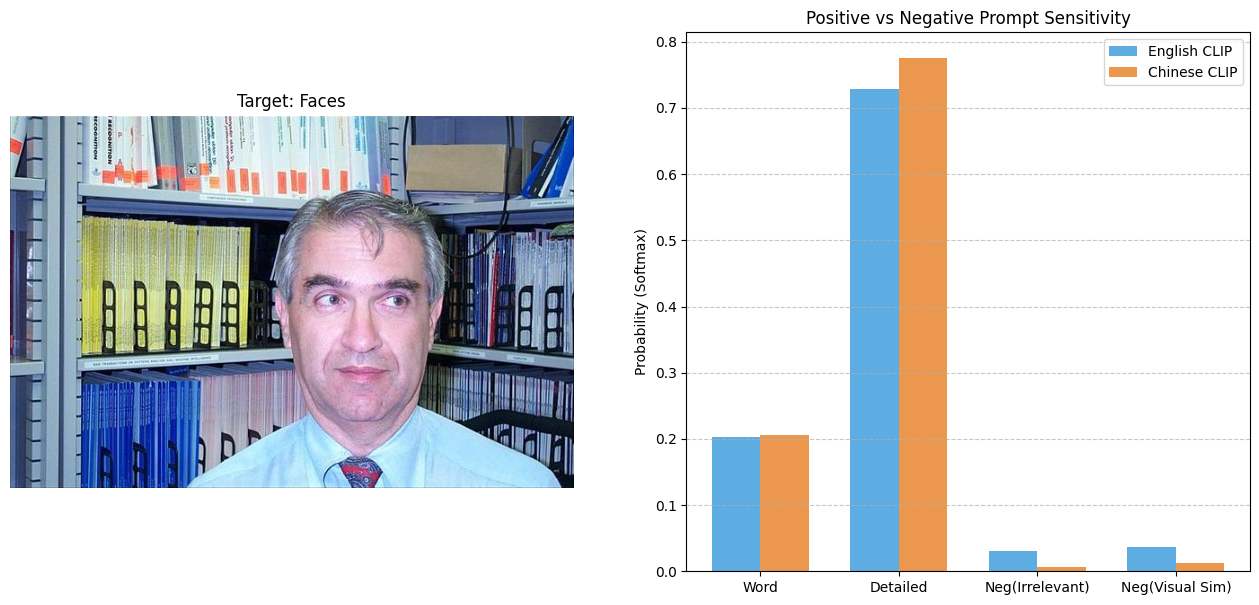

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, AutoModel
from torchvision.datasets import Caltech101
import random
import PIL.ImageStat as ImageStat
from deep_translator import GoogleTranslator

def get_main_color(image):
    """提取图片的主导色及其对应的干扰物体"""
    stat = ImageStat.Stat(image)
    # 获取 RGB 平均值
    r, g, b = stat.mean[:3]

    # 简单的颜色判定逻辑与配套的干扰项映射
    if r > g + 20 and r > b + 20:
        return ("红色", "red", "消防栓", "fire hydrant")
    elif g > r + 10 and g > b + 10:
        return ("绿色", "green", "森林", "forest")
    elif b > r + 10 and b > g + 10:
        return ("蓝色", "blue", "大海", "ocean")
    elif abs(r - g) < 20 and r > 150 and g > 150 and b < 100:
        return ("黄色", "yellow", "狮子", "lion")
    else:
        return ("灰色", "gray", "石头", "stone")

# 配置
EN_MODEL_ID = "openai/clip-vit-base-patch32"
ZH_MODEL_ID = "OFA-Sys/chinese-clip-vit-base-patch16"
DEVICE = "cpu"

def run_advanced_negative_exp(image_index=450):
    # 1. 加载数据
    dataset = Caltech101(root="./data", download=True)
    img, label_idx = dataset[image_index]
    true_label_en = dataset.categories[label_idx]

    # 2. 加载模型
    print("🔄 正在加载模型...")
    en_processor = CLIPProcessor.from_pretrained(EN_MODEL_ID)
    en_model = CLIPModel.from_pretrained(EN_MODEL_ID).to(DEVICE)
    zh_processor = AutoProcessor.from_pretrained(ZH_MODEL_ID)
    zh_model = AutoModel.from_pretrained(ZH_MODEL_ID).to(DEVICE)

    # 3. 改进的动态测试组构造
    all_categories = dataset.categories
    wrong_labels = [cat for cat in all_categories if cat != true_label_en]
    random_wrong = random.choice(wrong_labels)

    # 映射表
    zh_map = {
        "motorbikes": "摩托车", "sunflower": "向日葵", "airplanes": "飞机",
        "revolver": "左轮手枪", "cougar_face": "美洲狮", "Faces_easy": "人脸",
        "dalmatian": "斑点狗", "laptop": "笔记本电脑"
    }

    true_zh = zh_map.get(true_label_en, true_label_en)
    wrong_zh = zh_map.get(random_wrong, random_wrong)

# 在 run_advanced_negative_exp 函数内部：
    translator = GoogleTranslator(source='en', target='zh-CN')

# 获取中文名：先查表，查不到就在线翻
    true_zh = zh_map.get(true_label_en)
    if not true_zh:
      try:
          true_zh = translator.translate(true_label_en)
      except:
          true_zh = true_label_en # 实在不行才用英文

    # 翻译随机无关类别 (重要：确保负面描述也没有英文)
    wrong_zh = zh_map.get(random_wrong)
    if not wrong_zh:
        wrong_zh = translator.translate(random_wrong)
# 2. 【新增】动态获取颜色与视觉干扰项
    c_zh, c_en, obj_zh, obj_en = get_main_color(img)
    visual_sim_en = f"a {c_en} {obj_en}"
    visual_sim_zh = f"一个{c_zh}的{obj_zh}"

    # 3. 【修改】构造文本列表，引用动态生成的视觉干扰
    full_en = [
        f"{true_label_en}",
        f"a high-quality photo of a {true_label_en}",
        f"{random_wrong}",
        visual_sim_en  # 这里不再是固定的“模糊纹理”
    ]

    full_zh = [
        f"{true_zh}",
        f"一张高质量的{true_zh}照片",
        f"{wrong_zh}",
        visual_sim_zh  # 动态变为如“一张绿色的森林照片”
    ]
    # --- 核心：定义并执行推理函数 ---
    def get_probs(model, processor, texts, image):
        inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        # 获取图像与文本的相似度并做 softmax
        return outputs.logits_per_image.softmax(dim=1).numpy()[0]

    print("🧠 正在运行推理...")
    probs_en = get_probs(en_model, en_processor, full_en, img)
    probs_zh = get_probs(zh_model, zh_processor, full_zh, img)

    # 4. 可视化报告
    labels = ['Word', 'Detailed', 'Neg(Irrelevant)', 'Neg(Visual Sim)']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # 左图：原图
    ax1.imshow(img)
    ax1.set_title(f"Target: {true_label_en}")
    ax1.axis('off')

    # 右图：对比 (这里必须传入 probs 数值，而不是 full_en 文本)
    x = np.arange(len(labels))
    width = 0.35
    ax2.bar(x - width/2, probs_en, width, label='English CLIP', color='#3498DB', alpha=0.8)
    ax2.bar(x + width/2, probs_zh, width, label='Chinese CLIP', color='#E67E22', alpha=0.8)

    ax2.set_ylabel('Probability (Softmax)')
    ax2.set_title('Positive vs Negative Prompt Sensitivity')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.legend()

    from tabulate import tabulate

    table_data = []
    for i in range(len(labels)):
      table_data.append([labels[i], full_zh[i], full_en[i], f"{probs_zh[i]:.4f}", f"{probs_en[i]:.4f}"])

    print(tabulate(table_data,
               headers=['Test Type', 'Chinese Prompt', 'English Prompt', 'ZH Prob', 'EN Prob'],
               )) # grid 格式自带边框且对齐效果好

# 执行
run_advanced_negative_exp(image_index=101)


In [6]:
!pip install -q streamlit deep-translator transformers Pillow torch torchvision plotly tabulate
!npm install -q -g localtunnel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.2 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [7]:
%%writefile app.py
import streamlit as st
import torch
import numpy as np
import plotly.graph_objects as go
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, AutoModel
from torchvision.datasets import Caltech101
from PIL import Image
import PIL.ImageStat as ImageStat
import random
from deep_translator import GoogleTranslator

# --- 1. 模型加载缓存 ---
@st.cache_resource
def load_models():
    # 使用 CPU 运行（Colab 免费版显存有限，CPU 更稳）
    device = "cpu"
    # 英文模型
    en_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    en_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    # 中文模型
    zh_model = AutoModel.from_pretrained("OFA-Sys/chinese-clip-vit-base-patch16").to(device)
    zh_processor = AutoProcessor.from_pretrained("OFA-Sys/chinese-clip-vit-base-patch16")
    return en_model, en_processor, zh_model, zh_processor

# --- 2. 核心算法逻辑 ---
def get_main_color(image):
    stat = ImageStat.Stat(image)
    r, g, b = stat.mean[:3]
    if r > g + 20 and r > b + 20: return ("红色", "red", "消防栓", "fire hydrant")
    elif g > r + 10 and g > b + 10: return ("绿色", "green", "森林", "forest")
    elif b > r + 10 and b > g + 10: return ("蓝色", "blue", "大海", "ocean")
    elif abs(r - g) < 20 and r > 150 and g > 150 and b < 100: return ("黄色", "yellow", "狮子", "lion")
    else: return ("灰色", "gray", "石头", "stone")

def get_probs(model, processor, texts, image):
    inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits_per_image.softmax(dim=1).numpy()[0]

# --- 3. UI 界面 ---
st.set_page_config(page_title="CLIP 双语对比测试", layout="wide")
st.title("🇨🇳 CLIP 中英双语视觉语义实验室")

en_model, en_processor, zh_model, zh_processor = load_models()

with st.sidebar:
    st.header("实验设置")
    img_idx = st.number_input("Caltech101 索引", value=450)
    # 下载数据集
    dataset = Caltech101(root="./data", download=True)
    img, label_idx = dataset[img_idx]
    true_label_en = dataset.categories[label_idx]

    run_btn = st.button("🚀 运行对比测试", type="primary")

if run_btn:
    translator = GoogleTranslator(source='en', target='zh-CN')

    # 自动翻译逻辑
    true_zh = translator.translate(true_label_en)
    c_zh, c_en, obj_zh, obj_en = get_main_color(img)

    labels = ['Word', 'Detailed', 'Neg(Irrelevant)', 'Neg(Visual Sim)']
    full_en = [true_label_en, f"a high-quality photo of a {true_label_en}", "an irrelevant fruit", f"a {c_en} {obj_en}"]
    full_zh = [true_zh, f"一张高质量的{true_zh}照片", "一个无关的水果", f"一个{c_zh}的{obj_zh}"]

    probs_en = get_probs(en_model, en_processor, full_en, img)
    probs_zh = get_probs(zh_model, zh_processor, full_zh, img)

    # 左右布局
    col1, col2 = st.columns([1, 1.2])
    with col1:
        st.image(img, use_container_width=True, caption=f"目标物体: {true_label_en}")
        st.info(f"检测到主颜色: {c_zh} | 视觉干扰项: {obj_zh}")

    with col2:
        fig = go.Figure(data=[
            go.Bar(name='English CLIP', x=labels, y=probs_en, marker_color='#3498DB'),
            go.Bar(name='Chinese CLIP', x=labels, y=probs_zh, marker_color='#E67E22')
        ])
        fig.update_layout(barmode='group', yaxis_range=[0, 1], title="中英文模型置信度对比")
        st.plotly_chart(fig, use_container_width=True)

Writing app.py


In [11]:
!curl ipv4.icanhazip.com


34.26.125.214


In [12]:
# 1. 运行 Streamlit (后台运行)
!streamlit run app.py &>/content/logs.txt &

# 2. 启动 Localtunnel 穿透 8501 端口
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦your url is: https://open-moments-know.loca.lt
^C
